<a href="https://colab.research.google.com/github/anujgupta82/NLP_Bootcamp/blob/V_2_0/module4/CharacterEmbedding_SkipGram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train character embeddings using word2vec skipgram approach 

We look at ith character and try to predict (i-1) and (i+1) character

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131183 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.11-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.11-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redir

In [2]:
!ls /content/drive/NLP_bootcamp/Data/harry_potter_3.txt

/content/drive/NLP_bootcamp/Data/harry_potter_3.txt


In [0]:
#for inline plotting in notebooks
%matplotlib inline  

In [4]:
from keras.layers import Input, Dense
from keras.models import Model

Using TensorFlow backend.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Get data

In [6]:
# load data
path = "/content/drive/NLP_bootcamp/Data/harry_potter_3.txt"
text = open(path).read()

corpus_length = len(text)

print('corpus length:', corpus_length)

corpus length: 611606


In [7]:
unique_chars = list(set(text))
print('total no of unique chars:', len(unique_chars))

print ("\nSet of characters : \n" + str(unique_chars))

total no of unique chars: 79

Set of characters : 
['w', 'f', 'Q', 'y', 'a', 'B', 'O', 'L', '5', '&', '4', 'T', 'J', 'm', '_', 'q', '6', 'D', 'S', 'k', ':', 's', 'H', 'R', 'C', '"', "'", 'W', 'K', ')', 'P', 'p', '0', 'c', 'u', 'F', 'b', '\\', '3', 't', 'l', 'e', 'N', '!', '7', 'g', '9', '\n', 'j', 'Z', 'M', 'z', 'U', '*', '2', ' ', 'i', 'r', ',', 'v', 'n', '`', 'I', '?', '1', 'o', 'Y', 'G', ';', '-', 'X', '.', 'E', '(', 'd', 'x', 'h', 'A', 'V']


In [0]:
def classToOneHot(item, classes):

	x = [0. for _ in classes]
	
	x[classes.index(item)] = 1.

	return x

In [9]:
classToOneHot('a', unique_chars)

[0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [0]:
def findClosest(labels, coords, n=3):
	def dist(p1, p2):
		return np.linalg.norm(np.array(p1)-np.array(p2))
	for label, pos in zip(labels, coords):
		print(label)
		dists = []
		for l2, p2 in zip(labels, coords):
			if l2==label: continue
			dists.append((l2, dist(pos, p2)))
		dists = sorted(dists, key=lambda x : x[1])
		if n == -1:
			if dists[0][1] >= 0.2:
				print("\t{}\t{}".format(dists[0][0], dists[0][1]))
			else:
				for d in dists:
					if d[1] <= 0.15:
						print("\t{}\t{}".format(d[0], d[1]))
		else:		
			for d in dists[:n]:
				print("\t{}\t{}".format(d[0], d[1]))

In [0]:
# prepare training data X, y
# both X,y are are characters 

skip_window = 1 # how much we see on either side of center word
global_index = skip_window # 

X = []
y = []

for i in range(global_index, (corpus_length - skip_window)):

    #print i
    
    X_char = text[i]
    y1_char = text[i-1]
    y2_char = text[i+1]
    
    #print X_char
    #print y1_char, y2_char
    X.append(classToOneHot(X_char, unique_chars))
    yp=[classToOneHot(y1_char, unique_chars), classToOneHot(y2_char, unique_chars)] 
    
    y.append(yp)
    
X=np.array(X)    
    

In [12]:
print(np.shape(X), np.shape(y), (len(unique_chars),), )

(611604, 79) (611604, 2, 79) (79,)


In [13]:
nb_cols = len(y[0])
y_cols = [np.array([v[i] for v in y], np.float32) for i in range(nb_cols)]

input_layer = Input(shape=(len(unique_chars),))
encoding = Dense(2, activation='linear')(input_layer)

output_1 = Dense(len(unique_chars), activation='softmax')(encoding)
output_2 = Dense(len(unique_chars), activation='softmax')(encoding)

model = Model(inputs=[input_layer], outputs=[output_1, output_2])#, output_3, output_4])

encoder = Model(inputs = [input_layer], outputs=[encoding])

# when using larger windows, remember to add more loss weights
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', loss_weights=[0.5, 0.5])

#model.fit(X, y_cols, nb_epoch=15, batch_size=1024, shuffle=True, verbose=True)

In [14]:
model.fit(X , y_cols, epochs=15, batch_size=1024, shuffle=True, verbose=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/15
611604/611604 [==============================] - 8s 13us/step - loss: 3.7532 - dense_2_loss: 3.7663 - dense_3_loss: 3.7401
Epoch 2/15
611604/611604 [==============================] - 7s 11us/step - loss: 3.1199 - dense_2_loss: 3.1243 - dense_3_loss: 3.1155
Epoch 3/15
611604/611604 [==============================] - 7s 12us/step - loss: 3.0243 - dense_2_loss: 3.0225 - dense_3_loss: 3.0261
Epoch 4/15
611604/611604 [==============================] - 7s 11us/step - loss: 2.9917 - dense_2_loss: 2.9867 - dense_3_loss: 2.9968
Epoch 5/15
611604/611604 [==============================] - 7s 11us/step - loss: 2.9710 - dense_2_loss: 2.9660 - dense_3_loss: 2.9759
Epoch 6/15
611604/611604 [==============================] - 7s 11us/step - loss: 2.9546 - dense_2_loss: 2.9524 - dense_3_loss: 2.9568
Epoch 7/15
611604/611604 [==============================] - 7s 11us/step - loss: 2.9423 - dense_2_los

In [15]:
x2 = [classToOneHot(ch, unique_chars) for ch in unique_chars[:-1]]
encodings = encoder.predict(np.array(x2))
for ch, e in zip(unique_chars[:-1], encodings):
    print("{}\t{}\t{}".format(ch, e[0], e[1]))

w	-2.545854091644287	0.128388911485672
f	-2.3383584022521973	0.9405397176742554
Q	-1.945394515991211	-1.3868865966796875
y	-2.289656162261963	2.3939850330352783
a	-0.5912244915962219	0.780730128288269
B	-1.6627146005630493	-1.8436057567596436
O	-0.1904187798500061	-0.9589291214942932
L	-1.761541724205017	-2.103893995285034
5	-0.9248368740081787	0.5586948394775391
&	-0.6775332689285278	0.7584193348884583
4	-0.9952220916748047	0.4537416398525238
T	-0.9285984635353088	-0.677461564540863
J	-1.4980385303497314	-0.7622146010398865
m	-2.96665620803833	1.2342777252197266
_	-0.8159070611000061	0.4532845914363861
q	-1.6398882865905762	-0.9207335114479065
6	-0.8104060292243958	0.5539237856864929
D	-1.585982322692871	-1.761460781097412
S	-1.321016788482666	-1.0583393573760986
k	-2.850963830947876	1.3846962451934814
:	-0.6905620098114014	1.986785888671875
s	-2.6496379375457764	1.580122709274292
H	-2.4773707389831543	-2.5039992332458496
R	-1.728684902191162	-1.4328148365020752
C	-1.2195123434066772	

w
	h	0.1429605484008789
	b	0.27137380838394165
f
	p	0.19503894448280334
	l	0.25203970074653625
Q
	P	0.07797271013259888
	M	0.19836053252220154
y
	g	0.8500287532806396
	s	0.8899206519126892
a
	o	0.03642977401614189
	&	0.08914581686258316
B
	D	0.1124083548784256
	W	0.25369971990585327
O
	U	0.23880968987941742
	A	0.34658098220825195
L
	B	0.27841833233833313
	D	0.38481375575065613
5
	3	0.02224810980260372
	6	0.11453026533126831
&
	a	0.08914581686258316
	o	0.12454323470592499
4
	3	0.10474646091461182
	5	0.12636950612068176
T
	K	0.44226619601249695
	C	0.4551848769187927
J
	G	0.17667363584041595
	q	0.21271952986717224
m
	k	0.18976421654224396
	t	0.22702094912528992
_
	0	0.0967017114162445
	6	0.10078942775726318
q
	G	0.06290286779403687
	J	0.21271952986717224
6
	u	0.05757521837949753
	_	0.10078942775726318
D
	B	0.1124083548784256
	W	0.1425456702709198
S
	C	0.10607117414474487
	G	0.2908344566822052
k
	t	0.06145988777279854
	m	0.18976421654224396
:
	e	0.20969831943511963
	'	0.45003542304039
s
	t

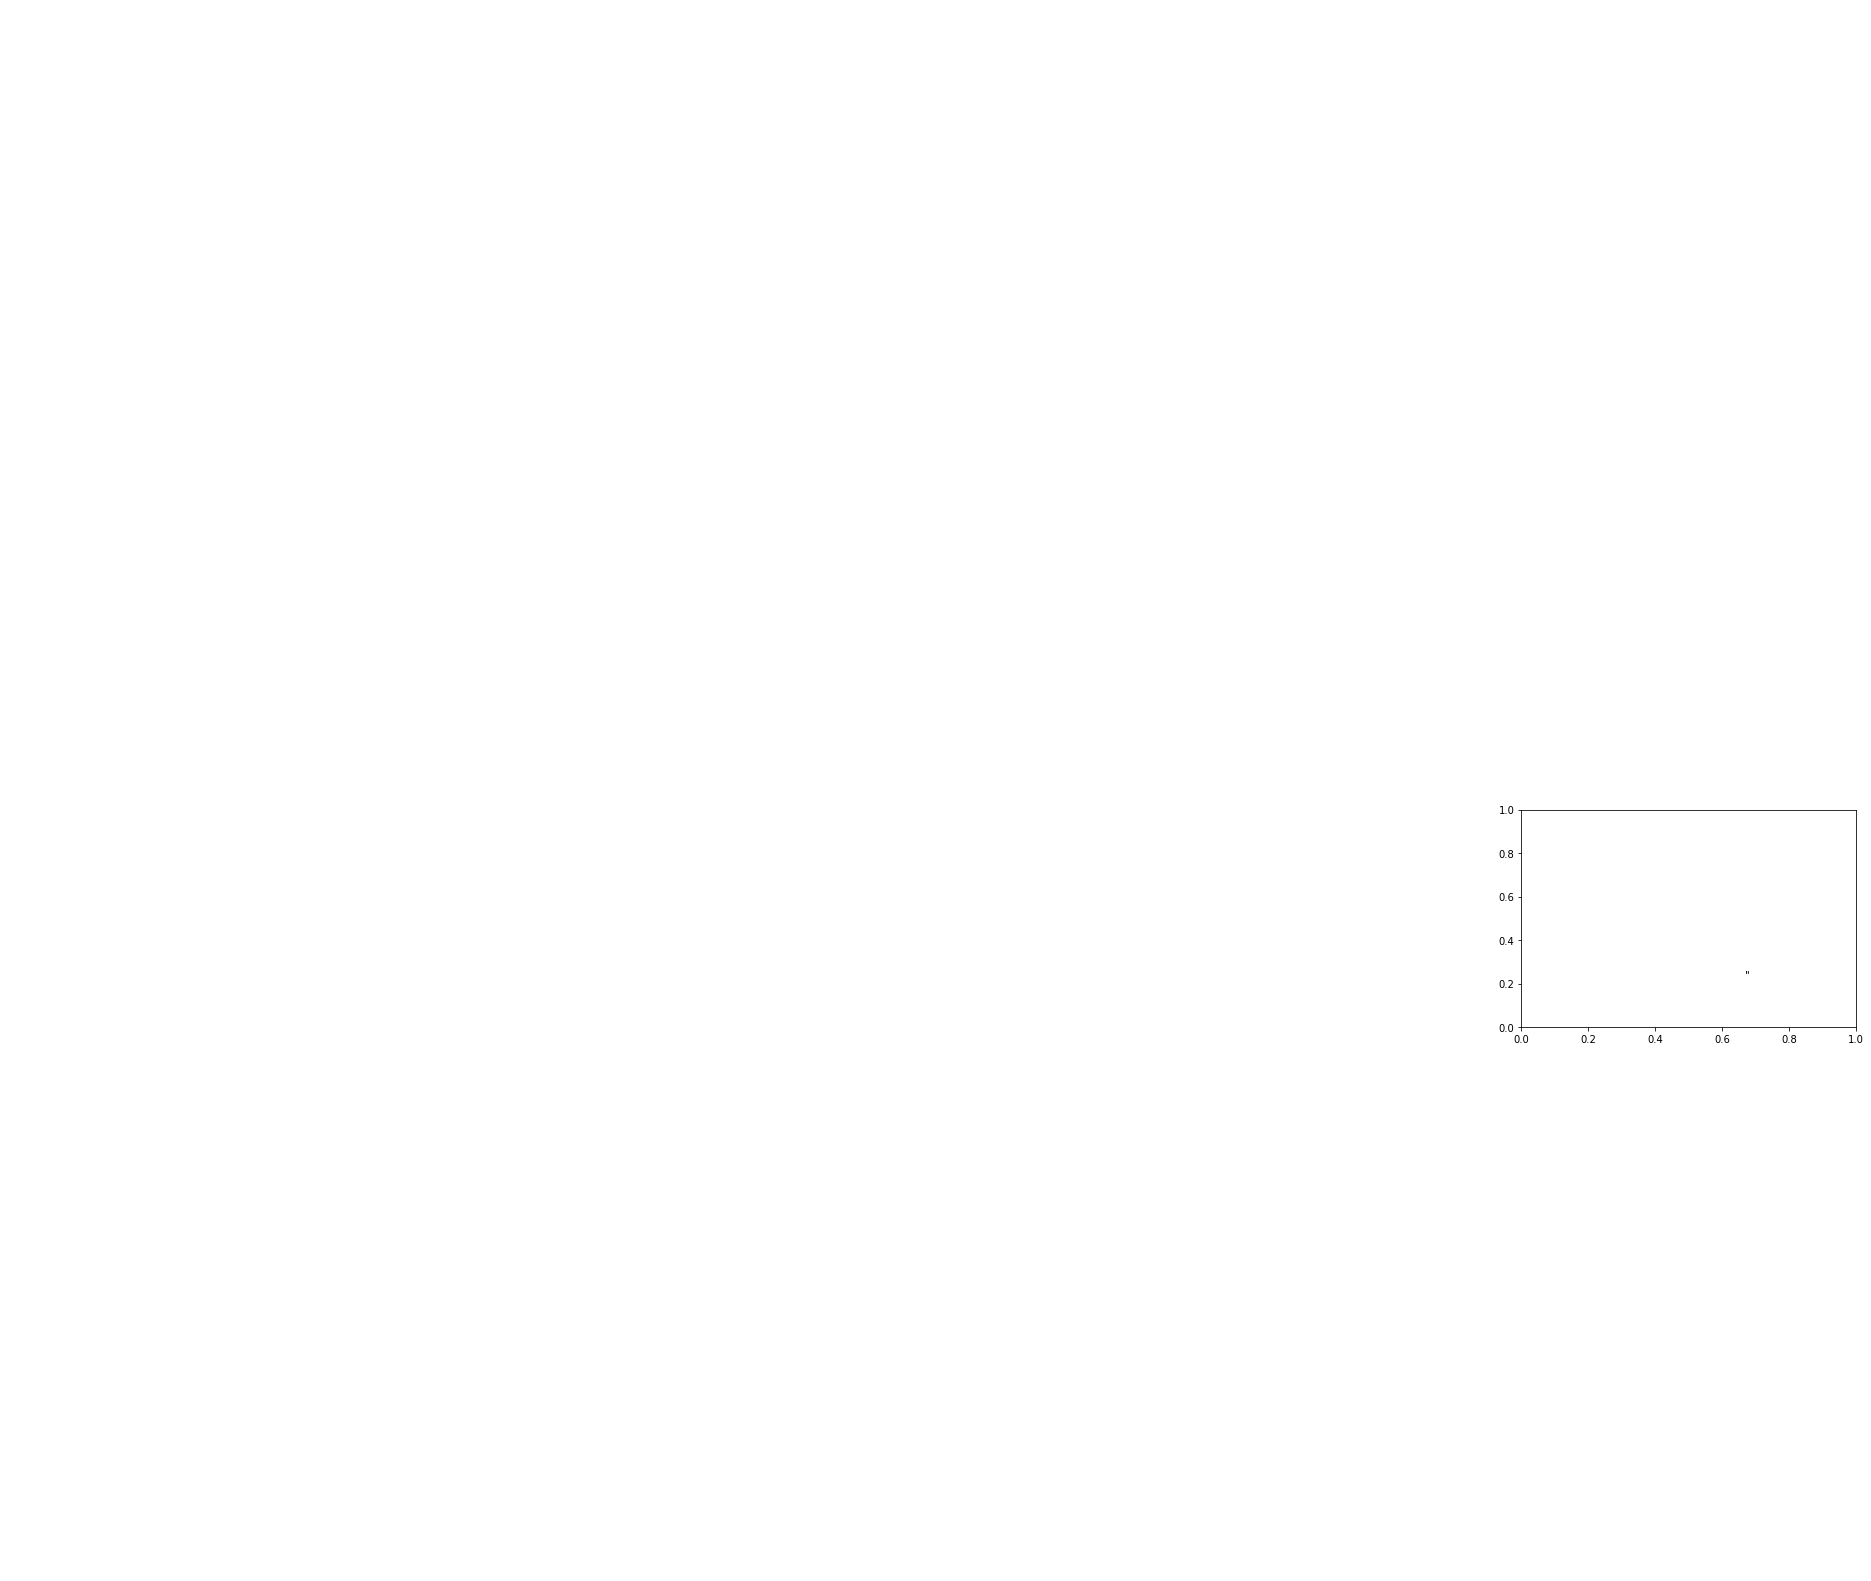

In [16]:
labels = unique_chars[:-1]
xd = [e[0] for e in encodings]
yd = [e[1] for e in encodings]
fig, ax = plt.subplots()
for i, txt in enumerate(labels):
    _ = ax.annotate(txt, (xd[i],yd[i]))


findClosest(labels, encodings, n=2)

plt.show()